In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map, crop_img

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def custom_plot(data, v, f, sulc, thr=1e-50, vmin=None, vmax=None, symmetric=False, figsize=(10,9),  cmap='coolwarm'):
    
    if vmin==None:
        vmin=np.nanmin(data)
    if vmax==None:
        vmax=np.nanmax(data)
        
    
    sns.set_style('white')
    lat=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True, darkness=0.4, 
                        elev=180,azim=0, figsize=figsize ,threshold=thr, cmap=cmap, 
                        symmetric_cbar=symmetric, vmin=vmin, vmax=vmax) 

    med=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True,darkness=0.4,
            elev=180,azim=180, figsize=figsize, threshold=thr, cmap=cmap, 
                           symmetric_cbar =symmetric, vmin=vmin, vmax=vmax) 

    lat_crop=crop_img(lat)
    med_crop=crop_img(med)

    fig=plt.figure()
    fig.set_size_inches(16, 8)
    ax1 = fig.add_subplot(121)
    plt.imshow(lat_crop)
    ax1.set_axis_off()
    ax2 = fig.add_subplot(122)
    plt.imshow(med_crop)
    ax2.set_axis_off()
    
    return fig

In [4]:
def plot_top(data, column):
    sns.set_style('white')
    fig=plot_surf_stat_map(v, f, stat_map=data[:,column], bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                    elev=270,azim=90, figsize=(10,8),cmap='jet', threshold=1e-50)
    
    fig_crop=crop_img(fig)
    fig=plt.figure()
    fig.set_size_inches(8, 8)
    ax1 = fig.add_subplot(111)
    plt.imshow(fig_crop)
    ax1.set_axis_off()

In [5]:
rh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl50.vtk'
lh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk'
rh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
lh_sulc_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
rh_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/rh_fullmask_new.npy'
lh_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/lh_fullmask_new.npy'

In [8]:
data_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'

In [9]:
rh_sulc=np.load(rh_sulc_file)
rh_mask=np.load(rh_mask_file)
rv, rf, rd = read_vtk(rh_mesh_file)
lh_sulc=np.load(lh_sulc_file)
lh_mask=np.load(lh_mask_file)
lv, lf, ld = read_vtk(lh_mesh_file)

In [10]:
data=np.load(data_file)
lh_data = data[:lv.shape[0]]
rh_data = data[lv.shape[0]:]

In [11]:
import pickle
pkl_file = open(dict_file, 'rb')
res = pickle.load(pkl_file)
pkl_file.close()
eigenval=res['lambdas']
orig_eigenval=res['orig_lambdas'][1:]
perc_var = eigenval/np.sum(eigenval)*100
orig_perc_var = orig_eigenval/np.sum(orig_eigenval)*100

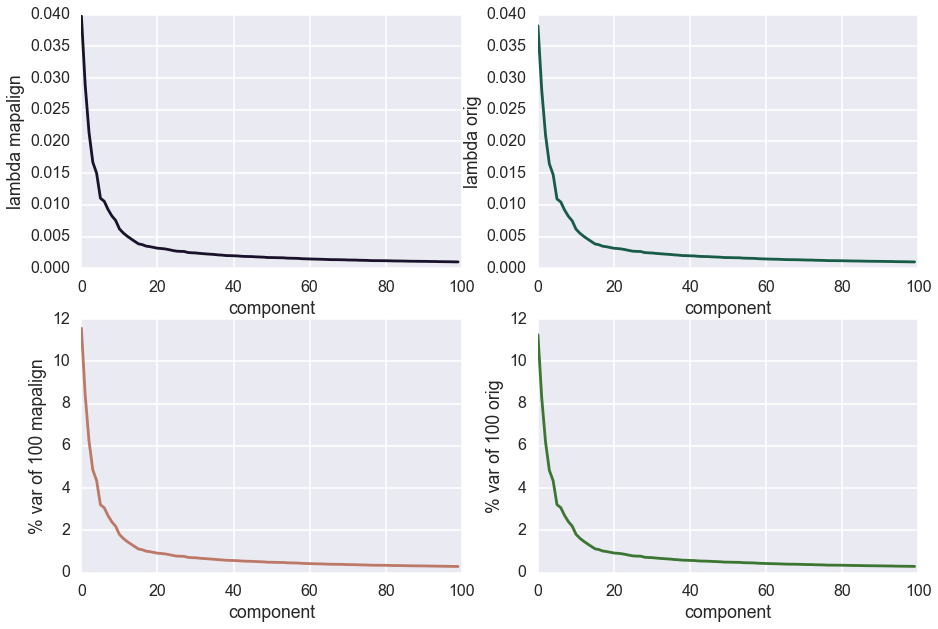

In [12]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig=plt.figure(figsize=(15,10))
fig.add_subplot(221)
plt.plot(eigenval, color=sns.color_palette('cubehelix', 10)[0])
plt.ylabel('lambda mapalign')
plt.xlabel('component')
fig.add_subplot(222)
plt.plot(orig_eigenval, color=sns.color_palette('cubehelix', 10)[2])
plt.ylabel('lambda orig')
plt.xlabel('component')
fig.add_subplot(223)
plt.plot(perc_var, color=sns.color_palette('cubehelix', 10)[5])
plt.ylabel('% var of 100 mapalign')
plt.xlabel('component')
fig.add_subplot(224)
plt.plot(orig_perc_var, color=sns.color_palette('cubehelix', 10)[3])
plt.ylabel('% var of 100 orig')
plt.xlabel('component')
#fig.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/indv_embed/%s_embed_both_100_lambda_var.png'%sub)

In [24]:
np.where(np.round(orig_perc_var, 1)>=1)[0].shape

(20,)

In [104]:
rh_data[rh_mask]=0
lh_data[lh_mask]=0

In [105]:
sns.set_style('white')
cropped_images_lh = []
for column in range(10):
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(lv, lf, stat_map=lh_data[:,column], bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,9) ,threshold=1e-50, cmap='cubehelix',
                            symmetric_cbar=False, vmin=lh_data[:,column].min(), vmax=lh_data[:,column].max())
        cropped_images_lh.append(crop_img(plot))

In [106]:
sns.set_style('white')
cropped_images_rh = []
for column in range(10):
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=rh_data[:,column], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='cubehelix',
                            symmetric_cbar=False, vmin=rh_data[:,column].min(), vmax=rh_data[:,column].max())
        cropped_images_rh.append(crop_img(plot))

In [107]:
cropped_img_comb = []
for img in range(int(len(cropped_images_lh)/2)):
    cropped_img_comb.append(cropped_images_lh[2*img])
    cropped_img_comb.append(cropped_images_lh[2*img+1])
    cropped_img_comb.append(cropped_images_rh[2*img])
    cropped_img_comb.append(cropped_images_rh[2*img+1])

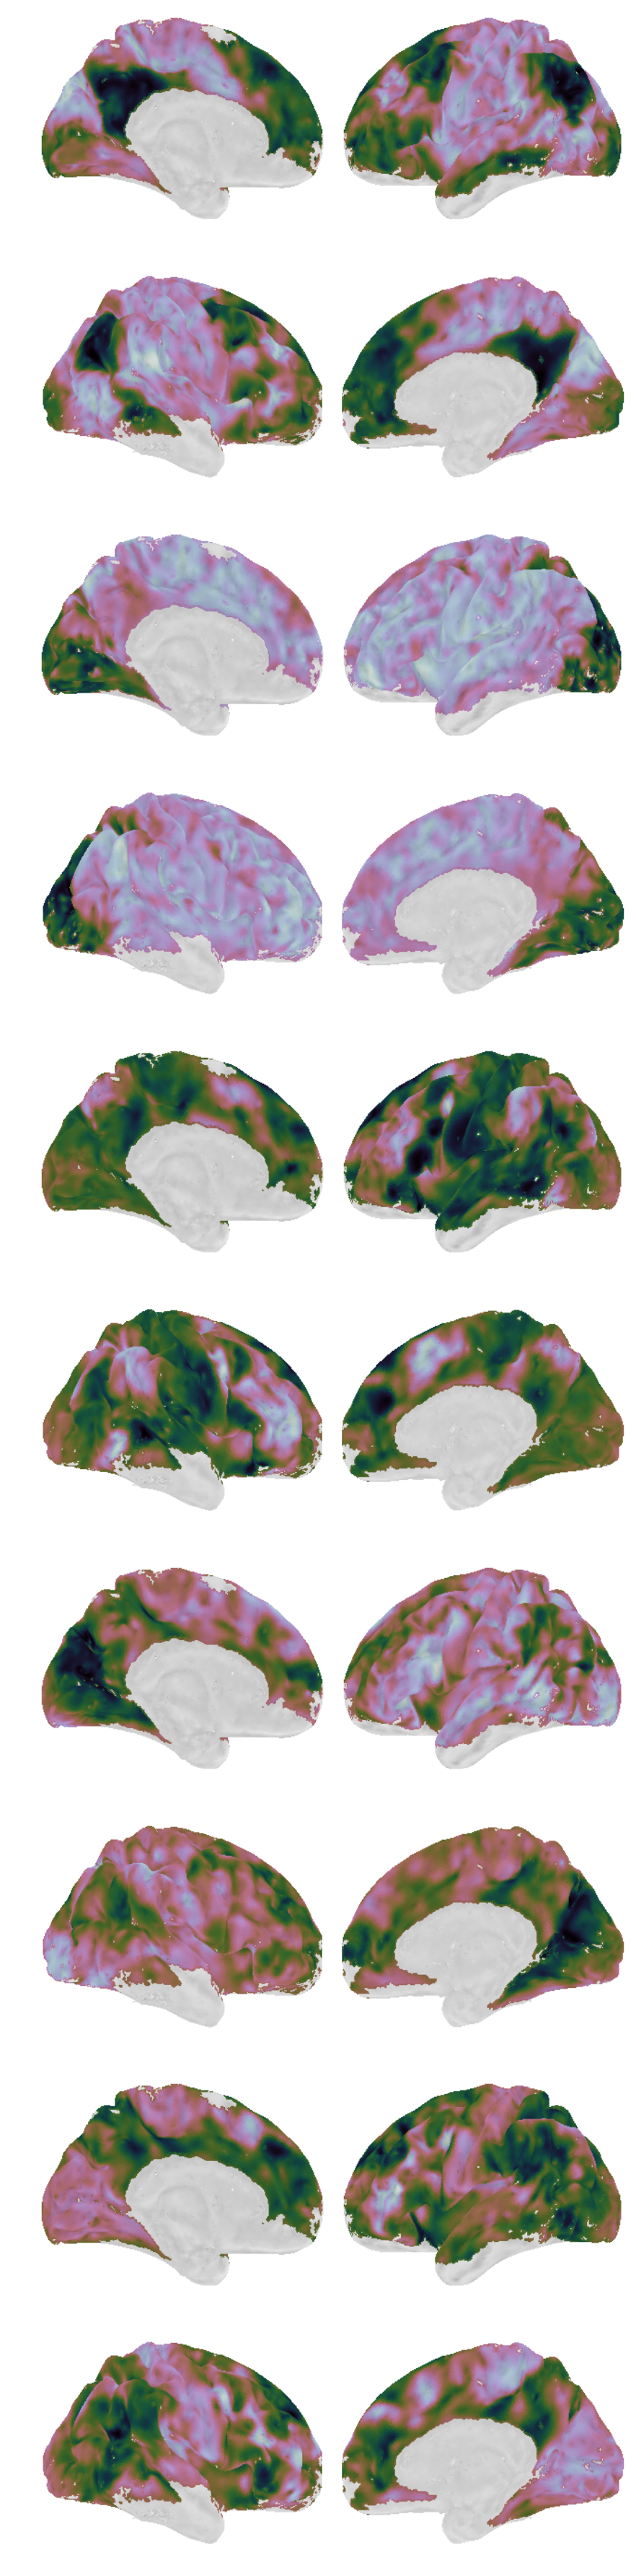

In [108]:
sns.set_style('white')
fig = plt.figure(figsize=(20,50))
for img in range(20):
    ax = fig.add_subplot(10,2,img+1)
    plt.imshow(cropped_img_comb[img])
    ax.set_axis_off
    ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(right=0.65)

In [109]:
fig.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/indv_embed/%s_embed_both_comp_1to10.png'%sub)

In [110]:
sub

'OL1T'